In [1]:
device = "cuda"



In [2]:
# load model

from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2-medium")
model = AutoModelForCausalLM.from_pretrained("gpt2-medium").to(device)

/home/xuan/seq_rationales/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
from rationalizer.aggregate_rationalizer import AggregateRationalizer
from rationalizer.importance_score_evaluator.delta_prob import DeltaProbImportanceScoreEvaluator
from rationalizer.stopping_condition_evaluator.top_k import TopKStoppingConditionEvaluator
from rationalizer.token_replacement.token_replacer.uniform import UniformTokenReplacer
from rationalizer.token_replacement.token_sampler.postag import POSTagTokenSampler

# construct rationalizer

rational_size = 5
rational_size_ratio = None

token_sampler = POSTagTokenSampler(tokenizer=tokenizer, device=device)

stopping_condition_evaluator = TopKStoppingConditionEvaluator(
    model=model, 
    token_sampler=token_sampler, 
    top_k=10, 
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio, 
    tokenizer=tokenizer
)

importance_score_evaluator = DeltaProbImportanceScoreEvaluator(
    model=model, 
    tokenizer=tokenizer, 
    token_replacer=UniformTokenReplacer(
        token_sampler=token_sampler, 
        ratio=0.3
    ),
    stopping_condition_evaluator=stopping_condition_evaluator,
    max_steps=3000
)

rationalizer = AggregateRationalizer(
    importance_score_evaluator=importance_score_evaluator,
    batch_size=5,
    overlap_threshold=2,
    overlap_strict_pos=True,
    top_n=rational_size, 
    top_n_ratio=rational_size_ratio
)


[POSTagTokenSampler] Loading vocab from tokenizer - 0.00%
[POSTagTokenSampler] Loading vocab from tokenizer - 9.95%
[POSTagTokenSampler] Loading vocab from tokenizer - 19.90%
[POSTagTokenSampler] Loading vocab from tokenizer - 29.85%
[POSTagTokenSampler] Loading vocab from tokenizer - 39.80%
[POSTagTokenSampler] Loading vocab from tokenizer - 49.74%
[POSTagTokenSampler] Loading vocab from tokenizer - 59.69%
[POSTagTokenSampler] Loading vocab from tokenizer - 69.64%
[POSTagTokenSampler] Loading vocab from tokenizer - 79.59%
[POSTagTokenSampler] Loading vocab from tokenizer - 89.54%
[POSTagTokenSampler] Loading vocab from tokenizer - 99.49%


In [52]:
input_string = "When my flight landed in Thailand. I was staying in the capital city of"

max_length = 25

# generate prediction 
input_ids = tokenizer(input_string, return_tensors='pt')['input_ids'][0].to(model.device)
generated_ids = model.generate(input_ids=torch.unsqueeze(input_ids, 0), max_length=max_length, do_sample=False)[0]
generated_texts = [ tokenizer.decode(token) for token in generated_ids ]
print(f'generated full sequence --> {generated_texts}')

import torch

# rationalize each generated token

importance_scores = []
importance_score_map = torch.zeros([generated_ids.shape[0] - input_ids.shape[0], generated_ids.shape[0] - 1])

for target_pos in torch.arange(input_ids.shape[0], generated_ids.shape[0]):
    # extract target
    target_id = generated_ids[target_pos]

    # rationalization
    pos_rational = rationalizer.rationalize(torch.unsqueeze(generated_ids[:target_pos], 0), torch.unsqueeze(target_id, 0))[0]

    ids_rational = generated_ids[pos_rational]
    text_rational = [ tokenizer.decode([id_rational]) for id_rational in ids_rational ]

    importance_score_map[target_pos - input_ids.shape[0], :target_pos] = rationalizer.mean_important_score

    print(f'{target_pos} / {generated_ids.shape[0]}')
    print(f'Target word     --> {tokenizer.decode(target_id)[0]}', )
    print(f"Rational pos    --> {pos_rational}")
    print(f"Rational text   --> {text_rational}")

    print()


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


generated full sequence --> ['When', ' my', ' flight', ' landed', ' in', ' Thailand', '.', ' I', ' was', ' staying', ' in', ' the', ' capital', ' city', ' of', ' Bangkok', '.', ' I', ' was', ' in', ' a', ' hotel', ' room', ' with', ' my']
15 / 25
Target word     -->  
Rational pos    --> tensor([ 0,  2,  4,  5,  8, 12, 13, 14], device='cuda:0')
Rational text   --> ['When', ' flight', ' in', ' Thailand', ' was', ' capital', ' city', ' of']

16 / 25
Target word     --> .
Rational pos    --> tensor([ 0,  1,  4,  6,  8,  9, 10, 13, 15], device='cuda:0')
Rational text   --> ['When', ' my', ' in', '.', ' was', ' staying', ' in', ' city', ' Bangkok']

17 / 25
Target word     -->  
Rational pos    --> tensor([ 1,  5,  7,  8,  9, 13, 15, 16], device='cuda:0')
Rational text   --> [' my', ' Thailand', ' I', ' was', ' staying', ' city', ' Bangkok', '.']

18 / 25
Target word     -->  
Rational pos    --> tensor([ 0,  2,  5,  6,  7,  9, 15, 16], device='cuda:0')
Rational text   --> ['When', ' flight

<Axes: xlabel='Importance distribution', ylabel='Target'>

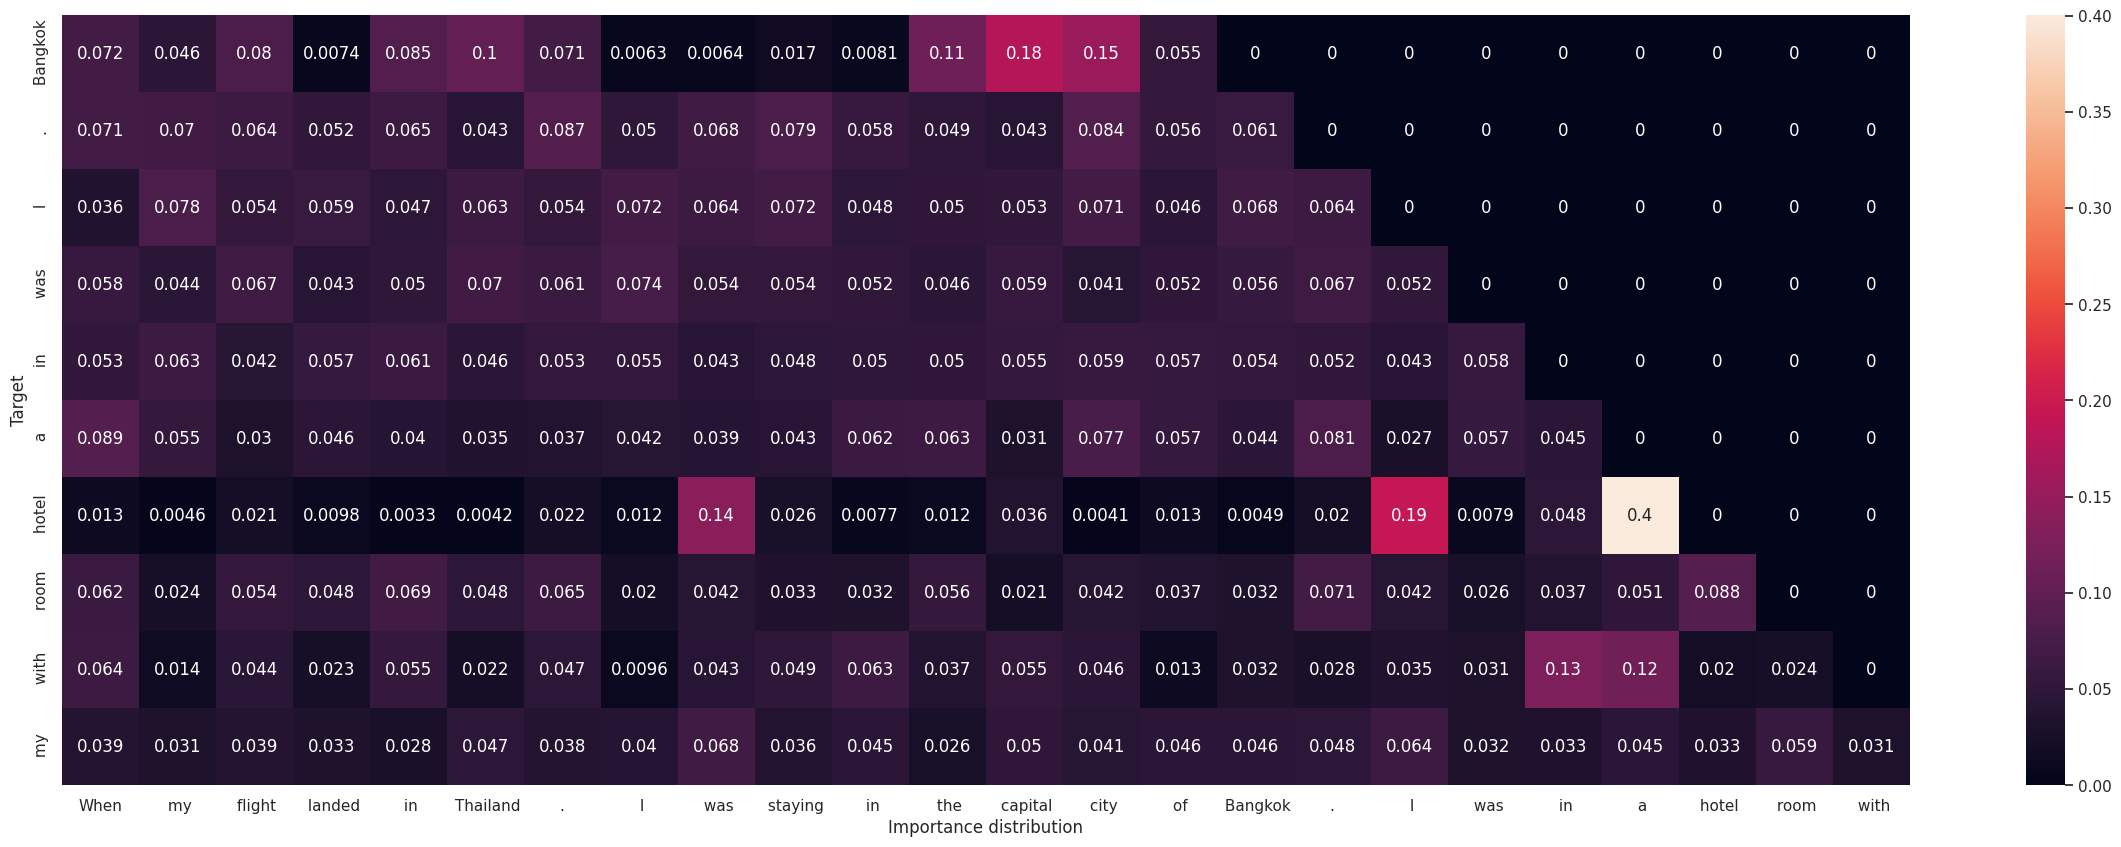

In [53]:
import seaborn
seaborn.set(rc={ 'figure.figsize': (30, 10) })
s = seaborn.heatmap(
    importance_score_map, 
    xticklabels=generated_texts[:-1], 
    yticklabels=generated_texts[input_ids.shape[0]:], 
    annot=True, 
    square=True)
s.set_xlabel('Importance distribution')
s.set_ylabel('Target')
s